In [42]:
# Deep Learning: 
# tokenizing, embedding, neural network, Analyze results

In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd

In [44]:
# loading the wine_reviews csv into 'data' DataFrame

url = "winemag-data-130k-v2_EDA.csv"
wine_reviews = pd.read_csv(url)
data = wine_reviews

In [45]:
data.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery', 'vintage',
       'avg points variety', 'avg points winery', 'pureTextdescription'],
      dtype='object')

In [46]:
# subset of columns to create X & Y

X = data[['country', 'price', 'taster_name', 'variety', 'winery',
          'vintage', 'avg points variety', 'avg points winery',
          'pureTextdescription']].copy()
y = data['points'].copy()

In [47]:
# vocabulary size max_words before NLP tokenization:

max_words = 10000

In [48]:
# Label encoding - target values converted into numerical

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [49]:
# tokenization
# builds a vocabulary based on frequency of occurrence in a specific textual columns: 'pureTextdescription', 'taster_name', 'country' 

tokenizer = Tokenizer(num_words=max_words) # maximum unique words to keep in the vocabulary
tokenizer.fit_on_texts(X['pureTextdescription'])
tokenizer.fit_on_texts(X['taster_name'])
tokenizer.fit_on_texts(X['country'])

In [50]:
# Model: Embedding, flattening, Concatenation, DNN setup

In [51]:
# convert textual columns into sequences of numerical tokens: 'pureTextdescription', 'taster_name', and 'country'
# Each sequence represents a sentence where each word is replaced by its corresponding integer index in the vocabulary.

X_text1 = tokenizer.texts_to_sequences(X['pureTextdescription'])
X_text2 = tokenizer.texts_to_sequences(X['taster_name'])
X_text3 = tokenizer.texts_to_sequences(X['country'])

In [52]:
# Normalize numerical features - to have mean 0 and standard deviation 1.
# creating a new DataFrame X_num contains only the normalized numerical features

scaler = StandardScaler()
X[['price', 'vintage', 'avg points variety', 'avg points winery']] = scaler.fit_transform(X[['price', 'vintage', 'avg points variety', 'avg points winery']])
X_num = X[['price', 'vintage', 'avg points variety', 'avg points winery']] 

In [53]:
# padding on sequences of text to have the same length before feeding data into neural networks

# finds the length of the longest sequence
max_seq_length1 =max(len(seq) for seq in X_text1)
max_seq_length2 =max(len(seq) for seq in X_text2)
max_seq_length3 =max(len(seq) for seq in X_text3)

# padding
X_text1 = pad_sequences(X_text1, maxlen=max_seq_length1)
X_text2 = pad_sequences(X_text2, maxlen=max_seq_length2)
X_text3 = pad_sequences(X_text3, maxlen=max_seq_length3)

In [54]:
max_seq_length1, max_seq_length2, max_seq_length3

(126, 4, 2)

In [55]:
# Split the data into training and testing sets
X_train_text1, X_test_text1, X_train_text2, X_test_text2,X_train_text3, X_test_text3, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text1, X_text2, X_text3, X_num, y, test_size=0.2, random_state=42)

In [56]:
# defining three input layers for textual features for neural network
# Each input layer with a specific type of text data and has a maximum sequence length

text_input_1 = Input(shape=(max_seq_length1,))
text_input_2 = Input(shape=(max_seq_length2,))
text_input_3 = Input(shape=(max_seq_length3,))

In [57]:
# embedding layers for textual features - represent words in a dense vector, where similar words are represented by similar vectors
# Each word will be represented by a vector of length 200

embedding_dim = 200
embedding_1 = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_1)
embedding_2 = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_2)
embedding_3 = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_3)

In [58]:
# Flatten the embeddings - converting the 2D or 3D tensor resulting from the embeddings into a 1D tensor
# will be used as inputs for the rest of the neural network

flatten_1 = Flatten()(embedding_1)
flatten_2 = Flatten()(embedding_2)
flatten_3 = Flatten()(embedding_3)

In [59]:
# input layer for the numerical features: 'price', 'vintage', 'avg points variety', 'avg points winery'

num_input = Input(shape=(4,))

In [60]:
# concatenating
# The Concatenate() layer will be a single tensor that includes both the flattened text embeddings and the numerical features

concatenated = Concatenate()([flatten_1, flatten_2, flatten_3, num_input])

In [61]:
# architecture of fully connected denses of neural network. neurons: 128,64,16
# output layer with a single neuron. the activation function is linear, which means it produces a continuous output.

x = Dense(128,  activation='relu')(concatenated) 
x = Dense(64,  activation='tanh')(concatenated)
x = Dense(16, activation='relu')(x)
output = Dense(1, activation='linear')(x)

In [62]:
# creating a Keras model using the Functional API

model = Model(inputs=[text_input_1, text_input_2,text_input_3, num_input], outputs=output)

In [63]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 126)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 126, 200)     2000000     ['input_5[0][0]']                
                                                                                            

In [64]:
plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, to_file='model_1.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [65]:
# Compile the model:
# The optimizer adjusts the model's weights during training to minimize the loss function.
# the mean squared error (MSE) is used as the loss function. MSE calculates the average squared difference between the predicted and actual values.
# metrics - list of additional evaluation metrics to be calculated during training. In this case, only the mean squared error is chosen.

model.compile(optimizer=Adam(learning_rate=0.00095),
              loss=MeanSquaredError(),
              metrics=[MeanSquaredError()])

In [66]:
# EarlyStopping - to prevent overfitting or over calculation

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',  # Tracker
    min_delta=0, # If the improvement is significant enough (greater than min_delta), the training continues
    patience=5, # The number of epochs with no improvement after which training will be stopped
    verbose=0, # verbosity of output
    mode='min', # monitoring the mean squared error, which we want to minimize.
    baseline=None, # If provided, training will stop if the monitored quantity is worse than the baseline
    restore_best_weights=True # restore the best weights
)

In [67]:
# Train the model

model.fit([X_train_text1, X_train_text2, X_train_text3, X_num_train], y_train,
          batch_size=32,    # 32 inputs is a batch
          epochs=20,    # number of times the entire training dataset is processed
          validation_data=([X_test_text1, X_test_text2, X_test_text3, X_num_test], y_test) # After each epoch, the model evaluates its performance
         , callbacks=[early_stopping_monitor]) # allowing using the early_stopping_monitor 

Epoch 1/20
2091/2091 [==============================] - 145s 69ms/step - loss: 3.1478 - mean_squared_error: 3.1473 - val_loss: 2.0242 - val_mean_squared_error: 2.0240
Epoch 2/20
2091/2091 [==============================] - 156s 74ms/step - loss: 1.3744 - mean_squared_error: 1.3741 - val_loss: 2.1487 - val_mean_squared_error: 2.1487
Epoch 3/20
2091/2091 [==============================] - 156s 75ms/step - loss: 0.7743 - mean_squared_error: 0.7743 - val_loss: 2.2460 - val_mean_squared_error: 2.2463
Epoch 4/20
2091/2091 [==============================] - 150s 72ms/step - loss: 0.5150 - mean_squared_error: 0.5150 - val_loss: 2.4280 - val_mean_squared_error: 2.4286
Epoch 5/20
2091/2091 [==============================] - 148s 71ms/step - loss: 0.4063 - mean_squared_error: 0.4063 - val_loss: 2.3450 - val_mean_squared_error: 2.3453
Epoch 6/20
2091/2091 [==============================] - 149s 71ms/step - loss: 0.3396 - mean_squared_error: 0.3397 - val_loss: 2.3758 - val_mean_squared_error: 2.376

In [68]:
# evaluate the model using the test dataset
# Lower values of loss and MSE indicate better performance
# the results should be compared to other models

loss, MSE = model.evaluate([X_test_text1,X_test_text2,X_test_text3,X_num_test], y_test)
print('Test Loss:', loss)
print('Test MSE:', MSE)

523/523 [==============================] - 2s 4ms/step - loss: 2.0242 - mean_squared_error: 2.0240
Test Loss: 2.0242202281951904
Test MSE: 2.0240252017974854


In [69]:
# R-squared score between the predicted values and the actual target values
# higher R-squared score generally indicates better model that explains the variance

r2_score(model.predict([X_test_text1,X_test_text2,X_test_text3, X_num_test]), y_test)

# result DNN R^2: 0.73

523/523 [==============================] - 2s 3ms/step


0.7325487914973017

In [70]:
# error analysis & improvement: identifying potential factors contributing to those errors

In [71]:
# y_predict - storing the model predictions

y_predict = model.predict([X_test_text1,X_test_text2,X_test_text3, X_num_test])

523/523 [==============================] - 2s 4ms/step


In [72]:
# converts the predicted values from a matrix format to a 1-dimensional array

y_predict=np.stack(y_predict, axis=1)[0] 

In [73]:
error = abs(y_predict -  y_test)
MAE = np.mean(error)
MAE

# result DNN MAE: 1.109

1.109819385646176

In [74]:
# total number of samples that were used for testing the model's predictions.

len(y_test)

16723

In [75]:
# total number of predictions

len(y_predict)

16723

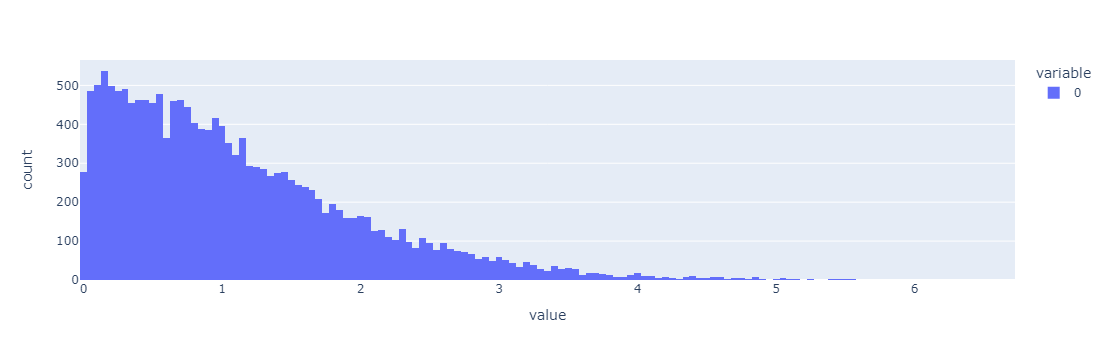

In [76]:
# histogram of the error values distribution

import plotly.express as px
px.histogram(error)

In [77]:
# adding columns to the testing set (X_test) to store the actual target values (y_test), the predicted values (y_predict), error values (error)

X_train, X_test = train_test_split(
    X, test_size=0.2, random_state=42)
X_test['y_test'] = y_test
X_test['y_predict'] = y_predict
X_test['error'] = error

In [78]:
# variable worst_error - selecting top 1000 rows from the testing set X_test based on the highest error values

worst_error = X_test.sort_values(by='error', ascending=False).head(1000)
worst_error

,country,price,taster_name,variety,winery,vintage,avg points variety,avg points winery,pureTextdescription,y_test,y_predict,error
18271,france,2.145696,roger voss,champagne blend,jacquart,-0.196455,3.105251,0.830720,this is a blend of premier and grand cru pinot...,6,12.679936,6.679936
6284,us,3.820747,unknown,cabernet sauvignon,b cellars,-0.196455,0.080459,1.451538,this cabernet sauvignon has enormously high al...,8,14.175776,6.175776
28637,us,-0.328226,virginie boone,mourvèdre,la clarine farm,0.079821,0.807308,0.434912,"light in color, alcohol and texture, this dyna...",15,8.831357,6.168643
52759,us,0.032554,virginie boone,red blend,hendry,-0.196455,-0.012977,-0.394927,"there's a chocolaty nose to this wine, a blend...",12,6.024125,5.975875
957,portugal,1.217975,roger voss,port,quinta vale dona maria,0.908650,1.827249,2.185858,this port comes from a good year for single-qu...,8,13.906371,5.906371
...,...,...,...,...,...,...,...,...,...,...,...,...
76749,france,-0.560156,roger voss,bordeaux-style red blend,maison bouey,0.079821,1.272723,-1.366878,this is a wine that is totally dominated by wo...,2,4.742933,2.742933
33091,us,-0.276686,unknown,petite sirah,quivira,-1.301560,-0.455001,0.262405,quivira is assemblng quite a track record with...,12,9.257802,2.742198
52622,italy,0.084094,unknown,red blend,cusumano,-1.025284,-0.012977,-0.392930,"noà is a successful blend of nero d'avola, mer...",11,8.258703,2.741297
81640,spain,-0.663236,michael schachner,moscato,tussock jumper,0.632374,-1.780776,-1.868056,textbook aromas of lychee and quince jelly ope...,7,4.259569,2.740431


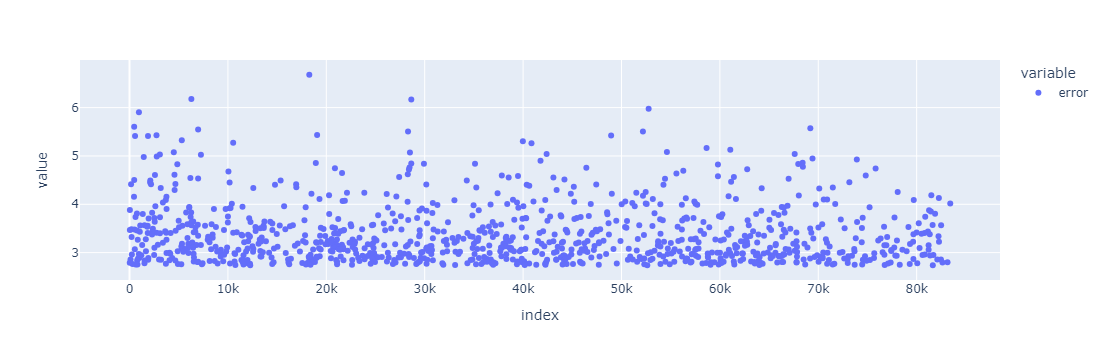

In [79]:
# scatter plot 1 - identify patterns in the distribution of prediction errors
# x-axis - data points in the worst_error  
# y-axis error 
px.scatter(worst_error.error, color_continuous_scale='green')

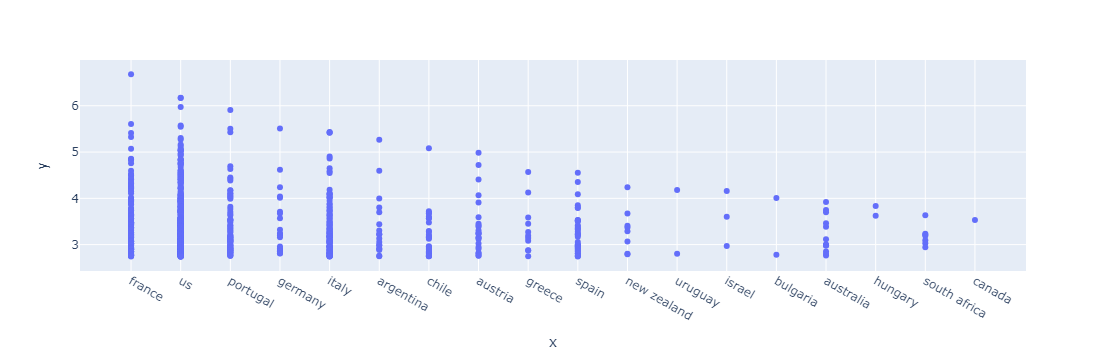

In [80]:
# scatter plot 2 - identify if there are certain countries associated with larger errors
# x-axis - 'country' in the worst_error 
# y-axis error 

px.scatter(x = worst_error.country, y = worst_error.error)

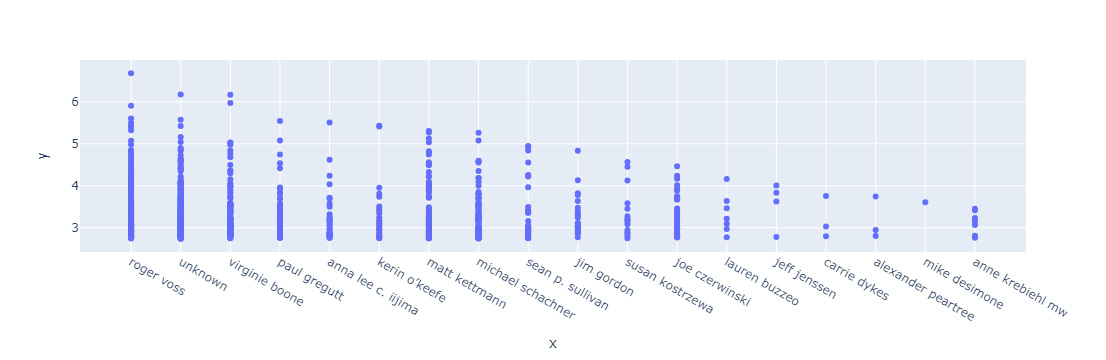

In [81]:
# scatter plot 3 - identify if there are certain tasters associated with larger errors
# x-axis - 'taster_name' in the worst_error 
# y-axis error 

px.scatter(x = worst_error.taster_name, y = worst_error.error)

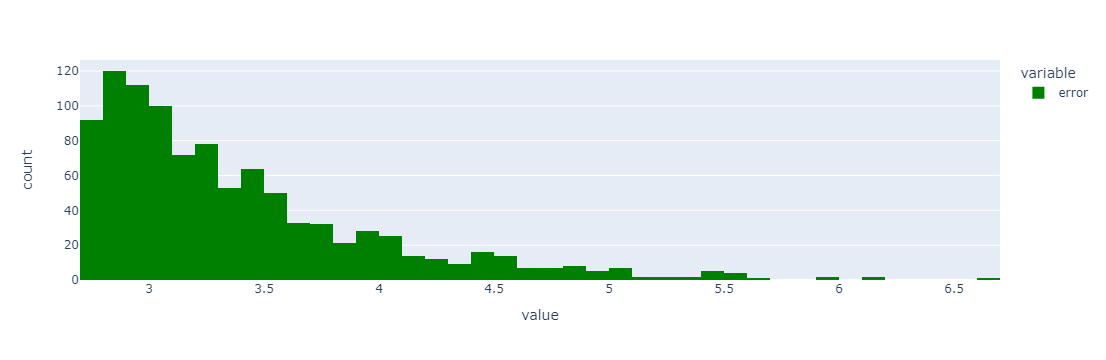

In [82]:
# histogram provides a visual representation of the distribution of prediction errors 

px.histogram(worst_error.error, color_discrete_sequence=['green'], labels='error')

In [83]:
final_results = {
    'model': ['linear regression', 'linear regression_ridge', 'deep'],
    'r^2': [0.780, 0.782, 0.732],  
    'mae': [1.13, 1.12, 1.109],  
    'mse': [2.08, 2.08, 2.02]   
}

df = pd.DataFrame(final_results)
print(df)

                     model    r^2    mae   mse
0        linear regression  0.780  1.130  2.08
1  linear regression_ridge  0.782  1.120  2.08
2                     deep  0.732  1.109  2.02
